# **Airbnb Data Mining -  Sentiment Analysis Notebook**
---

# Χριστοφιλοπούλου Βασιλική - sdi2000216
---

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Import Libraries**

In [2]:
# Download libraries
!pip install transformers
!pip install torch
!pip install pandas
!pip install gensim

# Import libraries
import sys
import os
import folium
import re
import torch
import nltk
import itertools
import pickle
import gensim

nltk.download('stopwords')
nltk.download('wordnet')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.downloader as api
# import seaborn as sns

from pandas import DataFrame, read_csv
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris


from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Ερώτημα 1: Study over time**

## **1.1.1:** Read the reviews.csv file and create the reviews_2019.csv

We will read the data using pandas' read_csv function and then process them in order to remove stop words.

In [3]:
inputPath = "/content/gdrive/MyDrive/data/2019"

#files we will use to concatenate
Files = ['/reviews.csv']

#the columns that the train set must have
columnlist = ['id','listing_id', 'comments']

Months = ['/april', '/february', '/march'] # 2019
Months2 = ['february','march','april']

framelist = []
monthlist = []
i=0
for month in Months:
    for file in Files:
        tempfile = pd.read_csv(inputPath+month+file,index_col = False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)

    # Initialize train with the first frame and combine with subsequent frames
    train = framelist[0]
    for l in range(1, len(framelist)):
        train = train.combine_first(framelist[l])

    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df2019 = pd.DataFrame(data = train, columns = columnlist)
    df2019.drop_duplicates(subset='id',ignore_index = True,inplace = True)  # id is primary key, no duplicates allowed in the same month
    df2019.insert(loc=len(df2019.columns),column='month_id',value = Months2[i])
    monthlist.append(df2019)
    i=i+1
df2019 = pd.concat(monthlist)
df2019.head()


,id,listing_id,comments,month_id
0,271535,10595,"The apartment was wonderful, fully equiped, be...",february
1,1994237,10595,Emmanouil was an excellent host. He provided u...,february
2,4678609,10595,"Manos is a very good host, he is kind and help...",february
3,12502994,10595,"Our stay in Emmanouil home was comfortable, qu...",february
4,19482948,10595,Fantastic accommodation very well located to v...,february


In [4]:
#Check how many data I have before I drop NaN values.
print(len(df2019))

862299


In [5]:
df2019.dropna(inplace=True)                       # If there are still mising data
print(len(df2019))


862134


Given that there are only 165 rows containing invalid or missing values, the impact of data loss is negligible.

In [6]:
# Now we have to remove stop words

#Process the text - Stop words
def preprocess_text(text):
    text = re.sub(r'[^\w\d\s]', ' ', text)                  # remove all punctuation
    ext = re.sub(r'[^\w\d\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', ' ', text) # remove emojis
    text = re.sub(r'\s+', ' ', text)                        # remove all whitespaces
    text = re.sub(r'^\s+|\s+?$', '', text.lower())          # from upper case to lower case
    stop_words = nltk.corpus.stopwords.words('english')     # remove stop words
    lemmatizer = WordNetLemmatizer()
    return ' '.join(
        lemmatizer.lemmatize(term)
        for term in text.split()
        if term not in set(stop_words)
    )

# Apply the text preprocessing function to the comments column
df2019['comments'] = df2019['comments'].apply(preprocess_text)
df2019.drop_duplicates(subset=['id'], keep='first', inplace=True)
df2019.head()

,id,listing_id,comments,month_id
0,271535,10595,apartment wonderful fully equiped beautiful de...,february
1,1994237,10595,emmanouil excellent host provided u everything...,february
2,4678609,10595,manos good host kind helpful apartment spaciou...,february
3,12502994,10595,stay emmanouil home comfortable quite perfect ...,february
4,19482948,10595,fantastic accommodation well located visit ath...,february


In [7]:
# Define the list of bad and good words
bad_words = [
    "terrible", "awful", "gross", "dirty", "disappointed", "horrible", "disgusting",
    "revolting", "nasty", "vile", "repulsive", "abysmal", "appalling", "atrocious",
    "dreadful", "lousy", "unpleasant", "shameful", "offensive", "unbearable",
    "wretched", "miserable", "horrific", "unsatisfactory", "inferior", "crappy",
    "abominable", "detestable", "deplorable", "awful", "abhorrent", "repugnant",
    "hideous", "grotesque", "repellent", "ghastly", "unspeakable", "execrable",
    "unacceptable", "objectionable", "unfortunate", "disgraceful", "forbidding",
    "foul", "stinking", "awry", "bum", "no-good", "rotten", "defective", "substandard",
    "dark", "broken", "pathetic", "worthless", "useless", "dismal", "grimy", "filthy",
    "sleazy", "squalid", "unclean", "inadequate", "poor", "pitiful", "rancid", "putrid",
    "loathsome", "reprehensible", "heinous", "scandalous", "shoddy", "crummy",
    "subpar", "horrendous", "atrocious", "insufferable", "distasteful", "horrid",
    "wretched", "dire", "unseemly", "lamentable", "gruesome", "disturbing", "distressing",
    "traumatic", "depressing", "unpleasant", "repelling", "abhorrent", "shocking",
    "deplorable", "terrifying", "horrifying", "scary", "nightmarish", "frightful",
    "unwelcome", "undesirable", "alarming", "ghastly", "appalling", "disheartening",
    "dispiriting", "bleak", "gloomy", "grim", "hopeless", "desperate", "direful",
    "ghoulish", "uncouth", "vulgar", "obscene", "off-putting", "broken", "malfunctioning",
    "unbearable", "noisy", "smelly", "cramped", "overpriced", "damp", "moldy", "inflexible",
    "rude", "unfriendly", "unprofessional", "incompetent", "misleading", "false advertising",
    "unsafe", "dangerous", "unsecured", "noisy neighbors", "bad location", "unhygienic",
    "overbooked", "cancelled", "unresponsive", "unreliable", "slow", "dirty sheets",
    "dirty towels", "broken furniture", "cold", "hot", "uncomfortable", "hard bed",
    "bad smell", "dirty kitchen", "dusty", "creaky", "old", "run-down", "shabby",
    "neglected", "broken window", "poor lighting", "no privacy", "noisy street", "construction noise",
    "far from center", "inconvenient", "poor service", "lack of amenities", "cold shower",
    "stained carpet", "inadequate heating", "inadequate cooling", "loud air conditioner",
    "bad wifi", "inconsistent wifi", "small bathroom", "bad plumbing", "clogged drain",
    "no hot water", "power outage", "long wait", "miscommunication", "unpleasant odor",
    "hard to find", "bad parking", "no parking", "uncomfortable sofa", "bad mattress",
    "broken lock", "dirty bathroom", "dirty floor", "noisy heating", "broken heater"]

good_words = [
    "great", "awesome", "glad", "happy", "excellent", "wonderful", "fantastic",
    "amazing", "terrific", "superb", "delighted", "satisfied", "pleased",
    "joyful", "ecstatic", "content", "blissful", "cheerful", "thrilled",
    "positive", "splendid", "fabulous", "perfect", "brilliant", "outstanding",
    "exceptional", "praiseworthy", "stellar", "first-rate", "top-notch",
    "commendable", "top", "smashing", "top-quality", "remarkable", "premium",
    "top-tier", "elite", "top-class", "high-quality", "exemplary", "superior",
    "sensational", "lovely", "amazing", "satisfactory", "adequate", "worthy",
    "super", "sufficient", "impressive", "fine", "stellar", "delightful", "tops"]


# Sample comments with bad and good words
df_sampled_bad_words = df2019[df2019['comments'].str.contains('|'.join(bad_words), case=False)]
df_sampled_good_words = df2019[df2019['comments'].str.contains('|'.join(good_words), case=False)]

# Filter comments not containing bad or good words
df_neutral_comments = df2019[~df2019['comments'].str.contains('|'.join(bad_words + good_words), case=False)]

# Sample required number of comments
df_sampled_bad_words = df_sampled_bad_words.sample(n=200, random_state=42, replace=True)  # Allow replacement if there are not enough bad comments
df_sampled_good_words = df_sampled_good_words.sample(n=600, random_state=42)
df_sampled_neutral_comments = df_neutral_comments.sample(n=200, random_state=42)

# Concatenate the sampled dataframes
df_final_sample19 = pd.concat([df_sampled_bad_words, df_sampled_good_words, df_sampled_neutral_comments], ignore_index=True)

# Save the DataFrame as a CSV file
df_final_sample19.to_csv('final_sampled_comments19.csv', index=False)


In [8]:

# Load the pre-trained sentiment analysis model and tokenizer
model_name = "j-hartmann/sentiment-roberta-large-english-3-classes"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model = pipeline("sentiment-analysis", model=model_name, tokenizer=tokenizer, return_all_scores=True)

# Load the new sampled comments data
df_final_sample19 = pd.read_csv('final_sampled_comments19.csv')

# Get sentiments for the sampled dataset
texts = df_final_sample19['comments'].tolist()
results = sentiment_model(texts, truncation=True, max_length=128)
df_final_sample19['sentiment'] = [max(result, key=lambda x: x['score'])['label'].lower() for result in results]

# Ensure we have 400 positive, 200 negative, and 200 neutral comments if possible
positive_comments_count = df_final_sample19[df_final_sample19['sentiment'] == 'positive'].shape[0]
negative_comments_count = df_final_sample19[df_final_sample19['sentiment'] == 'negative'].shape[0]
neutral_comments_count = df_final_sample19[df_final_sample19['sentiment'] == 'neutral'].shape[0]

# Sample the comments according to availability
positive_comments_sample_size = min(400, positive_comments_count)
negative_comments_sample_size = min(200, negative_comments_count)
neutral_comments_sample_size = min(200, neutral_comments_count)

positive_comments = df_final_sample19[df_final_sample19['sentiment'] == 'positive'].sample(n=positive_comments_sample_size, random_state=42)
negative_comments = df_final_sample19[df_final_sample19['sentiment'] == 'negative'].sample(n=negative_comments_sample_size, random_state=42)
neutral_comments = df_final_sample19[df_final_sample19['sentiment'] == 'neutral'].sample(n=neutral_comments_sample_size, random_state=42)

# Concatenate the balanced dataframes
df_final_balanced = pd.concat([positive_comments, negative_comments, neutral_comments], ignore_index=True)

# Select required columns and save to CSV
drive_path = '/content/gdrive/My Drive/'
df_result19 = df_final_balanced[['id', 'listing_id', 'comments', 'sentiment']]
df_result19.to_csv(drive_path + 'reviews2019.csv', index=False)

print(df_result19.head())

# Print the count of comments in each sentiment category after sampling
print()
print("Sentiment distribution after sampling:")
print(df_result19['sentiment'].value_counts())

# Count of comments in each sentiment category
positive_comments_count = len(df_result19[df_result19['sentiment'] == 'positive'])
negative_comments_count = len(df_result19[df_result19['sentiment'] == 'negative'])
neutral_comments_count = len(df_result19[df_result19['sentiment'] == 'neutral'])

# Calculate percentages
total_count = len(df_result19)
positive_percentage = (positive_comments_count / total_count) * 100
negative_percentage = (negative_comments_count / total_count) * 100
neutral_percentage = (neutral_comments_count / total_count) * 100

# Print percentages
print("Positive comments: {:.2f}%".format(positive_percentage))
print("Negative comments: {:.2f}%".format(negative_percentage))
print("Neutral comments: {:.2f}%".format(neutral_percentage))


tokenizer_config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


          id  listing_id                                           comments  \
0  284787950    11612054  athina amazing host communication good helpful...   
1   61885319     5788192  nasos wife really nice kind u explained u city...   
2  299475275    14480359  fantastic stay dimitrios place group consisted...   
3  311442599    27350589  lovely clean cosy studio 2min acropolis wonder...   
4  273454292    19796279  superb location close everything many restaura...   

  sentiment  
0  positive  
1  positive  
2  positive  
3  positive  
4  positive  

Sentiment distribution after sampling:
sentiment
positive    400
neutral     200
negative     24
Name: count, dtype: int64
Positive comments: 64.10%
Negative comments: 3.85%
Neutral comments: 32.05%


## **1.1.2:** Same steps in order create the reviews_2023.csv
We will read the data using pandas' read_csv function and then process them in order to remove stop words.

In [9]:
inputPath = "/content/gdrive/MyDrive/data/2023"

#files we will use to concatenate
Files = ['/reviews.csv']

#the columns that the train set must have
columnlist = ['id','listing_id', 'comments']

Months = ['/june', '/march', '/september'] # 2023
Months2 = ['march','june','september']

framelist = []
monthlist = []
i=0
for month in Months:
    for file in Files:
        tempfile = pd.read_csv(inputPath+month+file,index_col = False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)

    # Initialize train with the first frame and combine with subsequent frames
    train = framelist[0]
    for l in range(1, len(framelist)):
        train = train.combine_first(framelist[l])

    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df2023 = pd.DataFrame(data = train, columns = columnlist)
    df2023.drop_duplicates(subset='id',ignore_index = True,inplace = True)  # id is primary key, no duplicates allowed in the same month
    df2023.insert(loc=len(df2023.columns),column='month_id',value = Months2[i])
    monthlist.append(df2023)
    i=i+1
df2023 = pd.concat(monthlist)
df2023.head()


,id,listing_id,comments,month_id
0,271535,10595,"The apartment was wonderful, fully equiped, be...",march
1,1994237,10595,Emmanouil was an excellent host. He provided u...,march
2,12184199,695173,"My wife, my daughter and I spent five days of ...",march
3,13197921,695173,We had a great stay at Soula's apartment. We l...,march
4,13393565,695173,"Beautiful, clean apartment with plenty of spac...",march


In [10]:
#Check how many data I have before I drop NaN values.
print(len(df2023))

1739973


In [11]:
df2023.dropna(inplace=True)                       # If there are still mising data
print(len(df2023))
#df2023.to_csv("reviews2023.csv")

#df.head()

1739902


Given that there are only 71 rows containing invalid or missing values, the impact of data loss is negligible.

In [12]:
# Now we have to remove stop words

#Process the text - Stop words
def preprocess_text(text):
    text = re.sub(r'[^\w\d\s]', ' ', text)                  # remove all punctuation
    ext = re.sub(r'[^\w\d\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', ' ', text) # remove emojis
    text = re.sub(r'\s+', ' ', text)                        # remove all whitespaces
    text = re.sub(r'^\s+|\s+?$', '', text.lower())          # from upper case to lower case
    stop_words = nltk.corpus.stopwords.words('english')     # remove stop words
    lemmatizer = WordNetLemmatizer()
    return ' '.join(
        lemmatizer.lemmatize(term)
        for term in text.split()
        if term not in set(stop_words)
    )

# Apply the text preprocessing function to the comments column
df2023['comments'] = df2023['comments'].apply(preprocess_text)
df2023.drop_duplicates(subset=['id'], keep='first', inplace=True)
df2023.head()


,id,listing_id,comments,month_id
0,271535,10595,apartment wonderful fully equiped beautiful de...,march
1,1994237,10595,emmanouil excellent host provided u everything...,march
2,12184199,695173,wife daughter spent five day beauty light colo...,march
3,13197921,695173,great stay soula apartment loved decoration fu...,march
4,13393565,695173,beautiful clean apartment plenty space stayed ...,march


In [13]:
# Define the list of bad and good words
bad_words = [
    "terrible", "awful", "gross", "dirty", "disappointed", "horrible", "disgusting",
    "revolting", "nasty", "vile", "repulsive", "abysmal", "appalling", "atrocious",
    "dreadful", "lousy", "unpleasant", "shameful", "offensive", "unbearable",
    "wretched", "miserable", "horrific", "unsatisfactory", "inferior", "crappy",
    "abominable", "detestable", "deplorable", "awful", "abhorrent", "repugnant",
    "hideous", "grotesque", "repellent", "ghastly", "unspeakable", "execrable",
    "unacceptable", "objectionable", "unfortunate", "disgraceful", "forbidding",
    "foul", "stinking", "awry", "bum", "no-good", "rotten", "defective", "substandard",
    "dark", "broken", "pathetic", "worthless", "useless", "dismal", "grimy", "filthy",
    "sleazy", "squalid", "unclean", "inadequate", "poor", "pitiful", "rancid", "putrid",
    "loathsome", "reprehensible", "heinous", "scandalous", "shoddy", "crummy",
    "subpar", "horrendous", "atrocious", "insufferable", "distasteful", "horrid",
    "wretched", "dire", "unseemly", "lamentable", "gruesome", "disturbing", "distressing",
    "traumatic", "depressing", "unpleasant", "repelling", "abhorrent", "shocking",
    "deplorable", "terrifying", "horrifying", "scary", "nightmarish", "frightful",
    "unwelcome", "undesirable", "alarming", "ghastly", "appalling", "disheartening",
    "dispiriting", "bleak", "gloomy", "grim", "hopeless", "desperate", "direful",
    "ghoulish", "uncouth", "vulgar", "obscene", "off-putting", "broken", "malfunctioning",
    "unbearable", "noisy", "smelly", "cramped", "overpriced", "damp", "moldy", "inflexible",
    "rude", "unfriendly", "unprofessional", "incompetent", "misleading", "false advertising",
    "unsafe", "dangerous", "unsecured", "noisy neighbors", "bad location", "unhygienic",
    "overbooked", "cancelled", "unresponsive", "unreliable", "slow", "dirty sheets",
    "dirty towels", "broken furniture", "cold", "hot", "uncomfortable", "hard bed",
    "bad smell", "dirty kitchen", "dusty", "creaky", "old", "run-down", "shabby",
    "neglected", "broken window", "poor lighting", "no privacy", "noisy street", "construction noise",
    "far from center", "inconvenient", "poor service", "lack of amenities", "cold shower",
    "stained carpet", "inadequate heating", "inadequate cooling", "loud air conditioner",
    "bad wifi", "inconsistent wifi", "small bathroom", "bad plumbing", "clogged drain",
    "no hot water", "power outage", "long wait", "miscommunication", "unpleasant odor",
    "hard to find", "bad parking", "no parking", "uncomfortable sofa", "bad mattress",
    "broken lock", "dirty bathroom", "dirty floor", "noisy heating", "broken heater"]

good_words = [
    "great", "awesome", "glad", "happy", "excellent", "wonderful", "fantastic",
    "amazing", "terrific", "superb", "delighted", "satisfied", "pleased",
    "joyful", "ecstatic", "content", "blissful", "cheerful", "thrilled",
    "positive", "splendid", "fabulous", "perfect", "brilliant", "outstanding",
    "exceptional", "praiseworthy", "stellar", "first-rate", "top-notch",
    "commendable", "top", "smashing", "top-quality", "remarkable", "premium",
    "top-tier", "elite", "top-class", "high-quality", "exemplary", "superior",
    "sensational", "lovely", "amazing", "satisfactory", "adequate", "worthy",
    "super", "sufficient", "impressive", "fine", "stellar", "delightful", "tops"]


# Sample comments with bad and good words
df_sampled_bad_words = df2023[df2023['comments'].str.contains('|'.join(bad_words), case=False)]
df_sampled_good_words = df2023[df2023['comments'].str.contains('|'.join(good_words), case=False)]

# Filter comments not containing bad or good words
df_neutral_comments = df2023[~df2023['comments'].str.contains('|'.join(bad_words + good_words), case=False)]

# Sample required number of comments
df_sampled_bad_words23 = df_sampled_bad_words.sample(n=200, random_state=42, replace=True)  # Allow replacement if there are not enough bad comments
df_sampled_good_words23 = df_sampled_good_words.sample(n=600, random_state=42)
df_sampled_neutral_comments23 = df_neutral_comments.sample(n=200, random_state=42)

# Concatenate the sampled dataframes
df_final_sample23 = pd.concat([df_sampled_bad_words23, df_sampled_good_words23, df_sampled_neutral_comments23], ignore_index=True)

# Save the DataFrame as a CSV file
df_final_sample23.to_csv('final_sampled_comments23.csv', index=False)

In [14]:
# Load the pre-trained sentiment analysis model and tokenizer
model_name = "j-hartmann/sentiment-roberta-large-english-3-classes"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model = pipeline("sentiment-analysis", model=model_name, tokenizer=tokenizer, return_all_scores=True)

# Load the new sampled comments data
df_final_sample23 = pd.read_csv('final_sampled_comments23.csv')

# Get sentiments for the sampled dataset
texts = df_final_sample23['comments'].astype(str).tolist()
# texts = df_final_sample23['comments'].tolist()
results = sentiment_model(texts, truncation=True, max_length=128)
df_final_sample23['sentiment'] = [max(result, key=lambda x: x['score'])['label'].lower() for result in results]

# Ensure we have 400 positive, 200 negative, and 200 neutral comments if possible
positive_comments_count = df_final_sample23[df_final_sample23['sentiment'] == 'positive'].shape[0]
negative_comments_count = df_final_sample23[df_final_sample23['sentiment'] == 'negative'].shape[0]
neutral_comments_count = df_final_sample23[df_final_sample23['sentiment'] == 'neutral'].shape[0]

# Sample the comments according to availability
positive_comments_sample_size = min(400, positive_comments_count)
negative_comments_sample_size = min(200, negative_comments_count)
neutral_comments_sample_size = min(200, neutral_comments_count)

positive_comments = df_final_sample23[df_final_sample23['sentiment'] == 'positive'].sample(n=positive_comments_sample_size, random_state=42)
negative_comments = df_final_sample23[df_final_sample23['sentiment'] == 'negative'].sample(n=negative_comments_sample_size, random_state=42)
neutral_comments = df_final_sample23[df_final_sample23['sentiment'] == 'neutral'].sample(n=neutral_comments_sample_size, random_state=42)

# Concatenate the balanced dataframes
df_final_balanced = pd.concat([positive_comments, negative_comments, neutral_comments], ignore_index=True)

# Select required columns and save to CSV
drive_path = '/content/gdrive/My Drive/'
df_result23 = df_final_balanced[['id', 'listing_id', 'comments', 'sentiment']]
df_result23.to_csv(drive_path + 'reviews2023.csv', index=False)

print(df_result23.head())

# Print the count of comments in each sentiment category after sampling
print()
print("Sentiment distribution after sampling:")
print(df_result23['sentiment'].value_counts())

# Count of comments in each sentiment category
positive_comments_count = len(df_result23[df_result23['sentiment'] == 'positive'])
negative_comments_count = len(df_result23[df_result23['sentiment'] == 'negative'])
neutral_comments_count = len(df_result23[df_result23['sentiment'] == 'neutral'])

# Calculate percentages
total_count = len(df_result23)
positive_percentage = (positive_comments_count / total_count) * 100
negative_percentage = (negative_comments_count / total_count) * 100
neutral_percentage = (neutral_comments_count / total_count) * 100

# Print percentages
print("Positive comments: {:.2f}%".format(positive_percentage))
print("Negative comments: {:.2f}%".format(negative_percentage))
print("Neutral comments: {:.2f}%".format(neutral_percentage))


Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


                   id  listing_id  \
0  858437440515958609    50133966   
1  687422050712336657    54271815   
2           662771362     5732674   
3  865685033405376896    33550020   
4           489108313    13582987   

                                            comments sentiment  
0  wanted explore athens central location going p...  positive  
1    picture place amazing stop scrolling book place  positive  
2  great flat location kind host best experience ...  positive  
3  perfect apartment short stay athens br nearby ...  positive  
4  perfect apartment perfect location view temple...  positive  

Sentiment distribution after sampling:
sentiment
positive    400
neutral     200
negative     17
Name: count, dtype: int64
Positive comments: 64.83%
Negative comments: 2.76%
Neutral comments: 32.41%


## **1.2 A histogram of the sentiment analysis for each year**

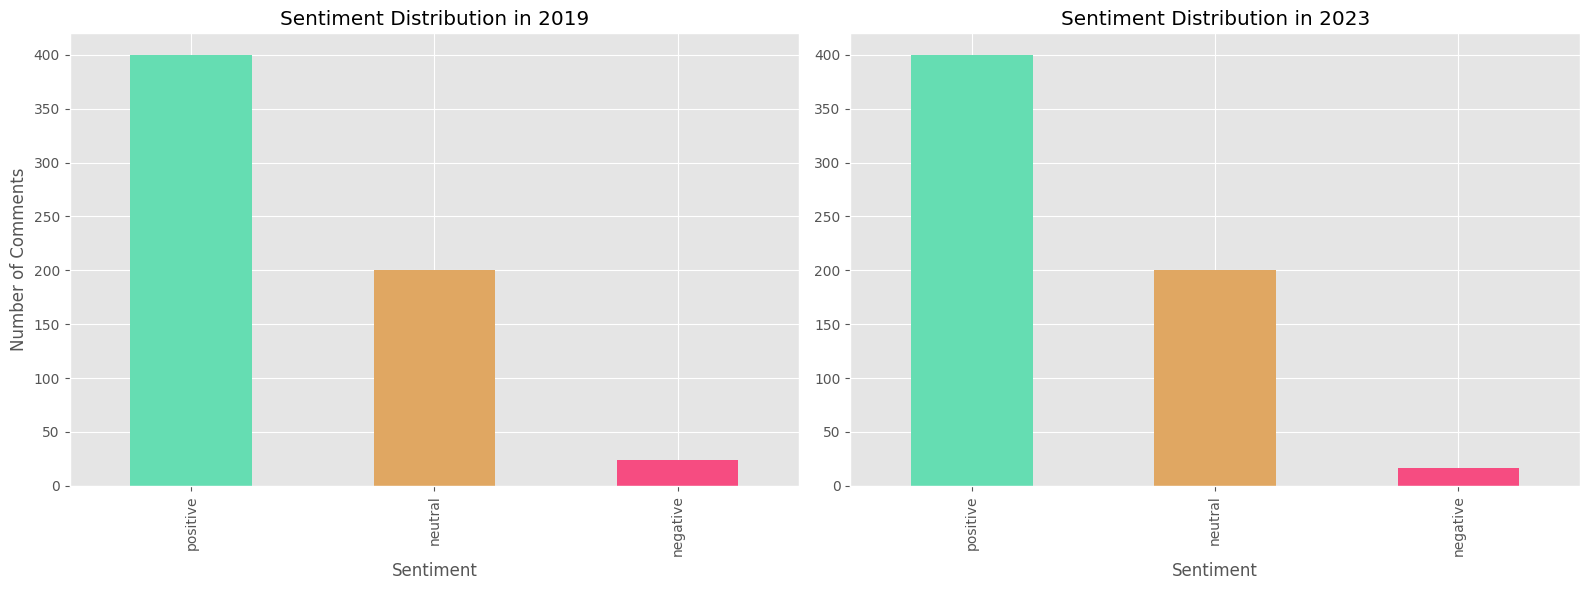

In [15]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

drive_path = "/content/gdrive/MyDrive/"
df_result19 = pd.read_csv(drive_path + "reviews2019.csv")
df_result23 = pd.read_csv(drive_path + "reviews2023.csv")

# Plot the data 2019
sentiment_counts_2019 = df_result19['sentiment'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)
sentiment_counts_2019.plot(kind='bar', color=['#65DDB2', '#E0A762', '#F64C81'], ax=axs[0])
axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Number of Comments')
axs[0].set_title('Sentiment Distribution in 2019')

# Plot the data 2023
sentiment_counts_2023 = df_result23['sentiment'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)
sentiment_counts_2023.plot(kind='bar', color=['#65DDB2', '#E0A762', '#F64C81'], ax=axs[1])
axs[1].set_xlabel('Sentiment')
axs[1].set_title('Sentiment Distribution in 2023')

plt.tight_layout()
plt.show()

## **1.3 A histogram of the sentiment analysis by neighborhood over time**

Here, i used the train2019 and train 2023 that i have created in the previous assignment, which I know are cleaned and have the correct data.

<Figure size 1500x1000 with 0 Axes>

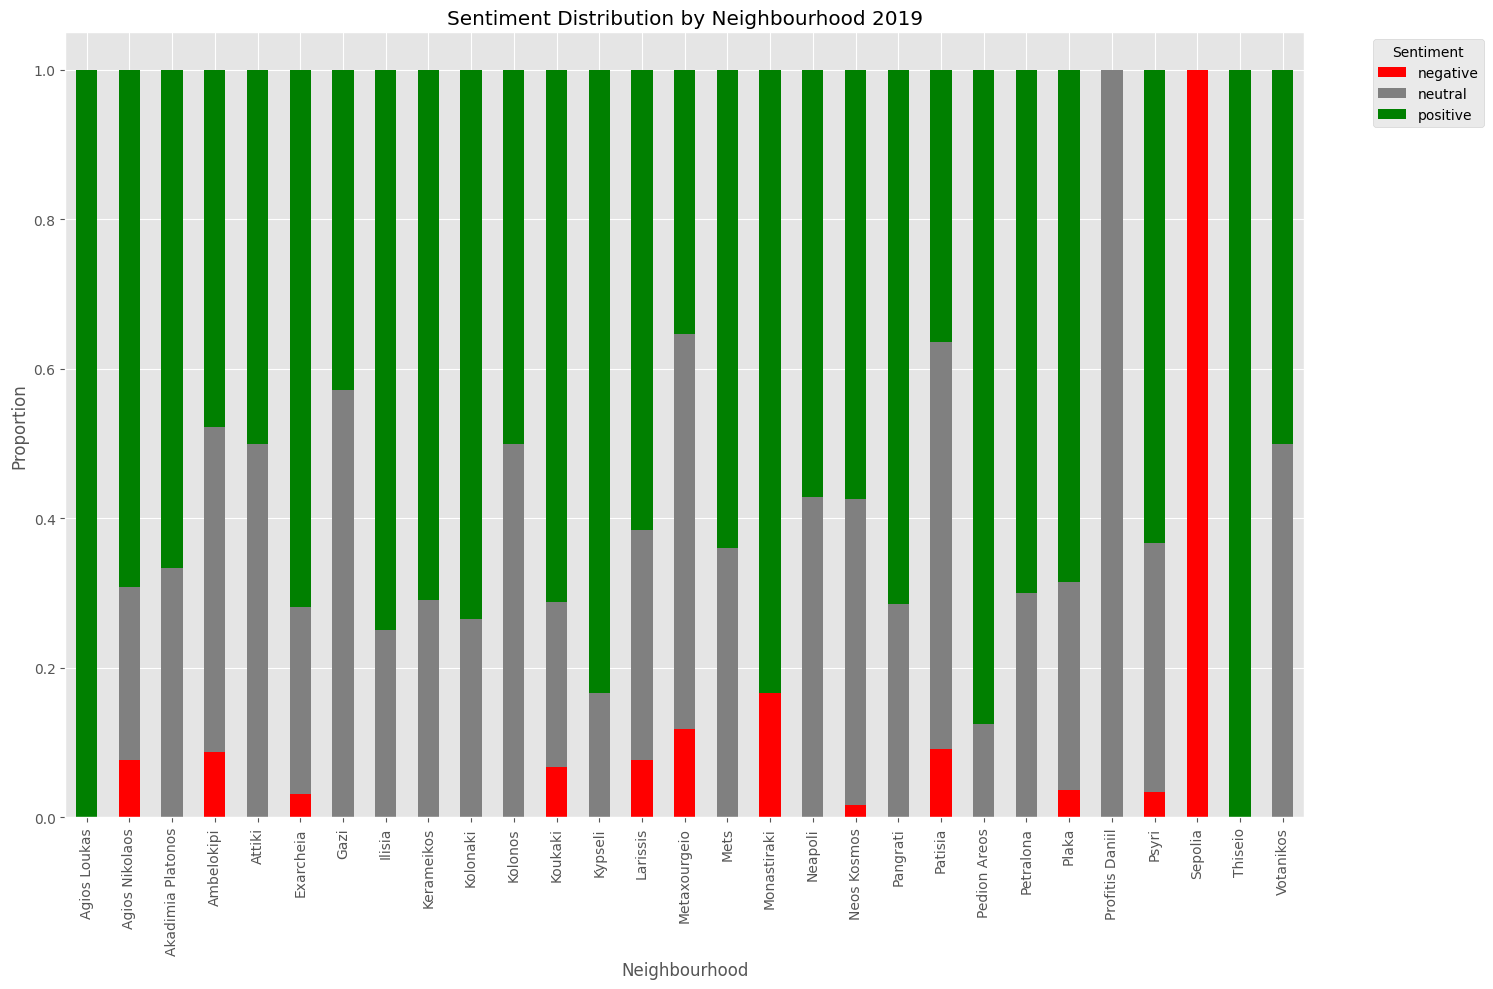

In [16]:
# Load the train dataset 2019
drive_path = "/content/gdrive/MyDrive/"
train_df = pd.read_csv(drive_path + "train2019.csv")
df_result19 = pd.read_csv(drive_path + "reviews2019.csv")

# Merge df_result19 with train_df on listing_id and id
merged_df = pd.merge(df_result19, train_df, how='left', left_on='listing_id', right_on='id')

# Clean and preprocess merged dataframe (optional: if needed)
merged_df.dropna(subset=['neighbourhood'], inplace=True)  # Drop rows with missing neighbourhoods

# Group by neighbourhood and calculate sentiment distribution
sentiment_counts = merged_df.groupby(['neighbourhood', 'sentiment']).size().unstack(fill_value=0)

# Normalize the sentiment counts to get proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Define colors for the sentiments
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'grey'}

# Plot sentiment proportions by neighbourhood
plt.figure(figsize=(15, 10))
sentiment_proportions.plot(kind='bar', stacked=True, color=[colors[col] for col in sentiment_proportions.columns], figsize=(15,10))
plt.title('Sentiment Distribution by Neighbourhood 2019')
plt.xlabel('Neighbourhood')
plt.ylabel('Proportion')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

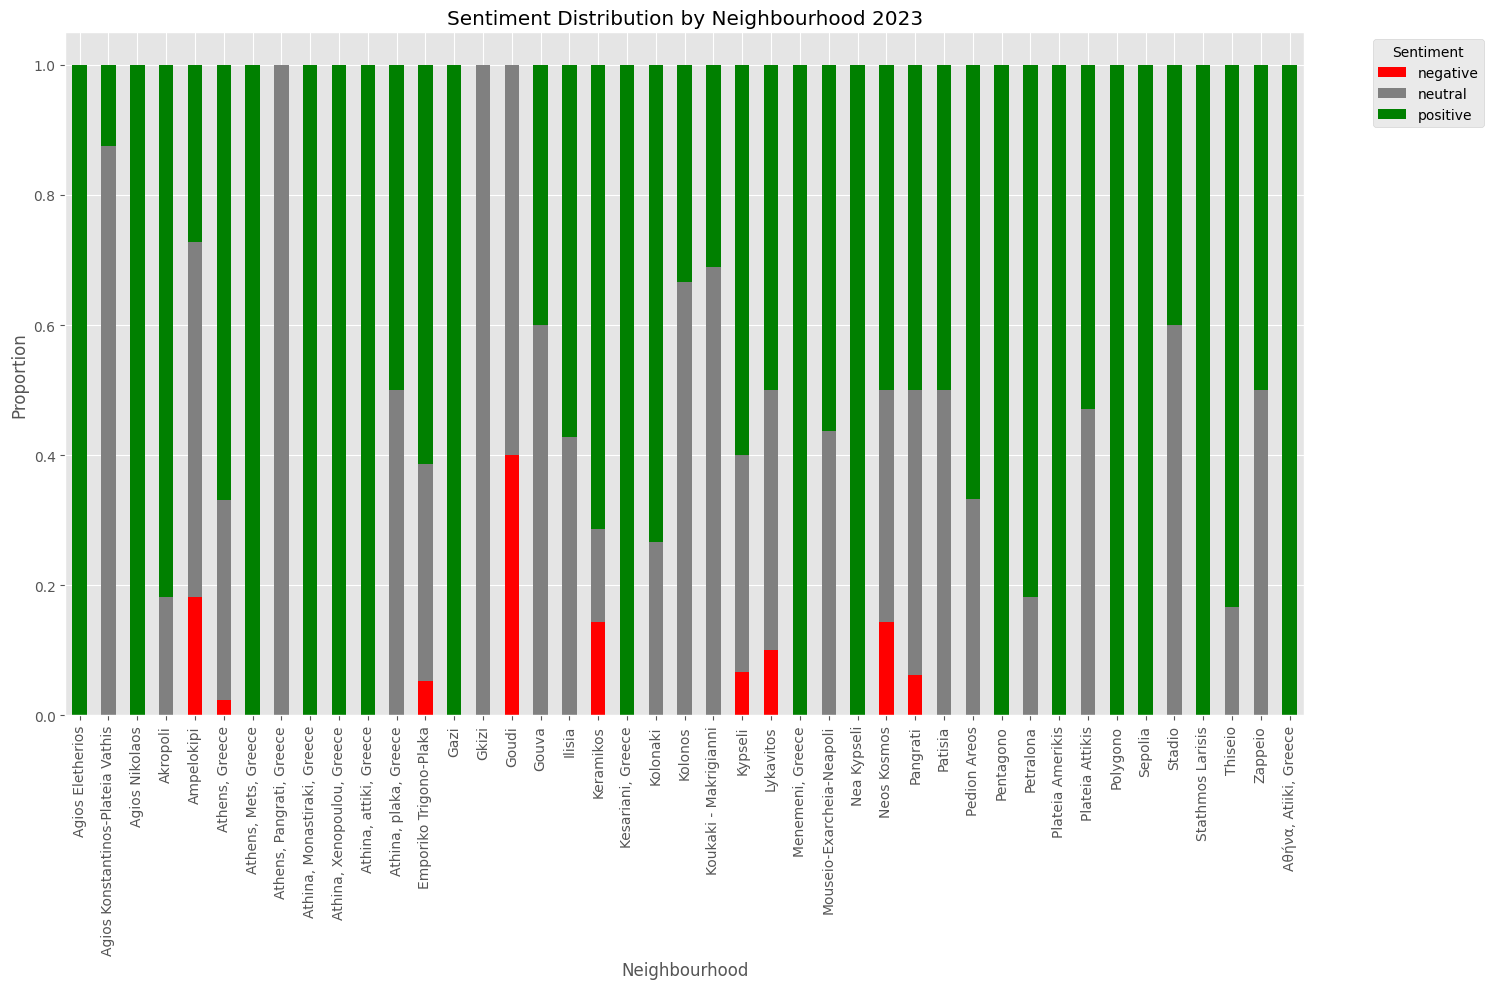

In [17]:
# Load the train dataset 2023
drive_path = "/content/gdrive/MyDrive/"
train_df = pd.read_csv(drive_path + "train2023.csv")
df_result23 = pd.read_csv(drive_path + "reviews2023.csv")

# Merge df_result23 with train_df on listing_id and id
merged_df = pd.merge(df_result23, train_df, how='left', left_on='listing_id', right_on='id')
merged_df.dropna(subset=['neighbourhood'], inplace=True)  # Drop rows with missing neighbourhoods

sentiment_counts = merged_df.groupby(['neighbourhood', 'sentiment']).size().unstack(fill_value=0)
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

colors = {'positive': 'green', 'negative': 'red', 'neutral': 'grey'}

# Plot sentiment proportions by neighbourhood
plt.figure(figsize=(15, 10))
sentiment_proportions.plot(kind='bar', stacked=True, color=[colors[col] for col in sentiment_proportions.columns], figsize=(15,10))
plt.title('Sentiment Distribution by Neighbourhood 2023')
plt.xlabel('Neighbourhood')
plt.ylabel('Proportion')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Ερώτημα 2: Sentiment Analysis**

## **2.1 Create train.tsv and test.tsv**

In [18]:
drive_path = '/content/gdrive/My Drive/'

# Import the CSV file into a DataFrame
df_result19 = pd.read_csv(drive_path + 'reviews2019.csv')
df_result23 = pd.read_csv(drive_path + 'reviews2023.csv')

df = pd.concat([df_result19, df_result23])

# Split the data into train and test sets
X = df.drop(columns=['sentiment'])
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save to csv files
X_train.to_csv(drive_path + 'X_train.csv', sep='\t', index=False)
X_test.to_csv(drive_path + 'X_test.csv', sep='\t', index=False)
y_train.to_csv(drive_path + 'y_train.csv', sep='\t', index=False, header=False)
y_test.to_csv(drive_path + 'y_test.csv', sep='\t', index=False, header=False)



print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Print the column names
print("Columns of X_train:", X_train.columns)

X_train shape: (992, 3)
X_test shape: (249, 3)
y_train shape: (992,)
y_test shape: (249,)
Columns of X_train: Index(['id', 'listing_id', 'comments'], dtype='object')


## **2.2.1 Create Tf-idf 2019 and 2023**

In [19]:
drive_path = '/content/gdrive/My Drive/'

X_train = pd.read_csv(drive_path + 'X_train.csv',sep='\t')
X_test = pd.read_csv(drive_path + 'X_test.csv',sep='\t')

# Handle missing values by filling NaNs with an empty string
X_train['comments'] = X_train['comments'].fillna('')
X_test['comments'] = X_test['comments'].fillna('')

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train['comments'])
X_test_tfidf = tfidf.transform(X_test['comments'])

#Save
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)
with open(drive_path + 'X_train_tfidf.pkl', 'wb') as f:
    pickle.dump(X_train_tfidf, f)
with open(drive_path + 'X_test_tfidf.pkl', 'wb') as f:
    pickle.dump(X_test_tfidf, f)

print("Tf-idf saved syccesfully.")

Tf-idf saved syccesfully.


## **2.2.1 Create Word embeddings 2019 and 2023**

In [11]:
#For Word embeddings we use Word2Vec.
drive_path = '/content/gdrive/My Drive/'

# Load the training and testing data from TSV files
X_train = pd.read_csv(drive_path + 'X_train.csv', sep='\t')
X_test = pd.read_csv(drive_path + 'X_test.csv', sep='\t')
y_test = pd.read_csv(drive_path + 'y_test.csv', sep='\t')

# Handle missing values by filling NaNs with empty strings
X_train['comments'] = X_train['comments'].fillna('')
X_test['comments'] = X_test['comments'].fillna('')

sentences = X_train['comments'].apply(lambda x: x.split())

#same code from slides for model Word2Vec
word2vec_model = gensim.models.Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    hs=0,
    negative=10,
    workers=4,
    seed=34
)

def get_word2vec_embeddings(text, model, dim=100, max_length=100):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if not word_vecs:
        return np.zeros((max_length, dim))
    padded_word_vecs = np.zeros((max_length, dim))
    padded_word_vecs[:min(max_length, len(word_vecs))] = word_vecs[:max_length]
    return padded_word_vecs


X_train_embeddings = np.array([get_word2vec_embeddings(text, word2vec_model) for text in X_train['comments']])
X_test_embeddings = np.array([get_word2vec_embeddings(text, word2vec_model) for text in X_test['comments']])


#Save
with open(drive_path + 'X_train_embeddings.pkl', 'wb') as f:
    pickle.dump(X_train_embeddings, f)

with open(drive_path + 'X_test_embeddings.pkl', 'wb') as f:
    pickle.dump(X_test_embeddings, f)

print("Word embeddings saved successfully.")


Word embeddings saved successfully.


In [12]:
# Extract top N most frequent words
N = 400
word_counts = Counter([word for sentence in sentences for word in sentence])
top_words = [word for word, _ in word_counts.most_common(N)]

# Filter out words not in the Word2Vec model's vocabulary
top_words = [word for word in top_words if word in word2vec_model.wv]

# Get embeddings for the top words
word_vectors = np.array([word2vec_model.wv[word] for word in top_words])

similarity_matrix = cosine_similarity(word_vectors)
similarity_df = pd.DataFrame(similarity_matrix, index=top_words, columns=top_words)

# Save the similarity matrix
similarity_df.to_pickle(drive_path + 'similarity_matrix.pkl')

print("Similarity matrix saved successfully.")

Similarity matrix saved successfully.


## **2.3 Classifier SVC**

### **2.3.1 Classifier SVC for Tf-idf**

In [22]:
#Load the data i need
drive_path = '/content/gdrive/My Drive/'
with open(drive_path + 'X_train_tfidf.pkl', 'rb') as f:
    X_train_tfidf = pickle.load(f)

with open(drive_path + 'X_test_tfidf.pkl', 'rb') as f:
    X_test_tfidf = pickle.load(f)

y_train = pd.read_csv(drive_path + 'y_train.csv', sep='\t', header=None)
y_test = pd.read_csv(drive_path + 'y_test.csv', sep='\t', header=None)


model = SVC()
model.fit(X_train_tfidf, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# cross validation
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=10)
print("Results of cross validation:", cv_scores)
print()
print("Mean cross validation score:", cv_scores.mean())


# Final evaluation on the test set
test_score = model.score(X_test_tfidf, y_test.values.ravel())  # ravel() to convert y_test to 1D array
print("Final test score:", test_score)

# #Print metrics
# Predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Calculate metrics
precision = precision_score(y_test, y_pred, average='macro') * 100
recall = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
accuracy = accuracy_score(y_test, y_pred) * 100

# Print metrics
print()
print("-----------------------------------------------------")
print("Classifier SVC for Tf-idf.")
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F-Measure: {:.2f}%".format(f1))
print("Accuracy: {:.2f}%".format(accuracy))
print("-----------------------------------------------------")

Results of cross validation: [0.82       0.85       0.92929293 0.83838384 0.86868687 0.86868687
 0.87878788 0.90909091 0.88888889 0.85858586]

Mean cross validation score: 0.871040404040404
Final test score: 0.8795180722891566

-----------------------------------------------------
Classifier SVC for Tf-idf.
Precision: 92.34%
Recall: 66.47%
F-Measure: 71.71%
Accuracy: 87.95%
-----------------------------------------------------


### **2.3.2 Classifier SVC for word embeddings**

In [23]:
#Load the data i need
drive_path = '/content/gdrive/My Drive/'
with open(drive_path + 'X_train_embeddings.pkl', 'rb') as f:
    X_train_embeddings = pickle.load(f)

with open(drive_path + 'X_test_embeddings.pkl', 'rb') as f:
    X_test_embeddings = pickle.load(f)

y_train = pd.read_csv(drive_path + 'y_train.csv', sep='\t', header=None)
y_test = pd.read_csv(drive_path + 'y_test.csv', sep='\t', header=None)

# Flatten the embeddings
X_train_embeddings = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1)
X_test_embeddings = X_test_embeddings.reshape(X_test_embeddings.shape[0], -1)

model = SVC()
model.fit(X_train_embeddings, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# cross validation
cv_scores = cross_val_score(model, X_train_embeddings, y_train, cv=10)
print("Results of cross validation:", cv_scores)
print()
print("Mean cross validation score:", cv_scores.mean())


# Final evaluation on the test set
test_score = model.score(X_test_embeddings, y_test.values.ravel())  # ravel() to convert y_test to 1D array
print("Final test score:", test_score)

# #Print metrics
# Predictions on the test set
y_pred = model.predict(X_test_embeddings)

# Calculate metrics
precision = precision_score(y_test, y_pred, average='macro') * 100
recall = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
accuracy = accuracy_score(y_test, y_pred) * 100

# Print metrics
print()
print("-----------------------------------------------------")
print("Classifier SVC for Word Embeddings.")
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F-Measure: {:.2f}%".format(f1))
print("Accuracy: {:.2f}%".format(accuracy))
print("-----------------------------------------------------")

Results of cross validation: [0.82       0.84       0.92929293 0.82828283 0.86868687 0.85858586
 0.86868687 0.88888889 0.88888889 0.85858586]

Mean cross validation score: 0.864989898989899
Final test score: 0.8714859437751004

-----------------------------------------------------
Classifier SVC for Word Embeddings.
Precision: 58.68%
Recall: 58.13%
F-Measure: 58.20%
Accuracy: 87.15%
-----------------------------------------------------


## **2.4 Classifier Random Forests**

### **2.4.1 Classifier Random Forests for Tf-idf**

In [24]:
#Load the data i need
drive_path = '/content/gdrive/My Drive/'
with open(drive_path + 'X_train_tfidf.pkl', 'rb') as f:
    X_train_tfidf = pickle.load(f)

with open(drive_path + 'X_test_tfidf.pkl', 'rb') as f:
    X_test_tfidf = pickle.load(f)

y_train = pd.read_csv(drive_path + 'y_train.csv', sep='\t', header=None)
y_test = pd.read_csv(drive_path + 'y_test.csv', sep='\t', header=None)


model = RandomForestClassifier()
model.fit(X_train_tfidf, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# cross validation
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=10)
print("Results of cross validation:", cv_scores)
print()
print("Mean cross validation score:", cv_scores.mean())


# Final evaluation on the test set
test_score = model.score(X_test_tfidf, y_test.values.ravel())  # ravel() to convert y_test to 1D array
print("Final test score:", test_score)

# #Print metrics
# Predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Calculate metrics
precision = precision_score(y_test, y_pred, average='macro') * 100
recall = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
accuracy = accuracy_score(y_test, y_pred) * 100

# Print metrics
print()
print("-----------------------------------------------------")
print("Classifier SVC for Tf-idf.")
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F-Measure: {:.2f}%".format(f1))
print("Accuracy: {:.2f}%".format(accuracy))
print("-----------------------------------------------------")

Results of cross validation: [0.82       0.84       0.92929293 0.83838384 0.86868687 0.85858586
 0.87878788 0.90909091 0.88888889 0.85858586]

Mean cross validation score: 0.8690303030303029
Final test score: 0.8875502008032129

-----------------------------------------------------
Classifier SVC for Tf-idf.
Precision: 92.76%
Recall: 67.30%
F-Measure: 72.40%
Accuracy: 88.76%
-----------------------------------------------------


### **2.4.2 Classifier Random Forests for word embeddings**

In [25]:
#Load the data i need
drive_path = '/content/gdrive/My Drive/'
with open(drive_path + 'X_train_embeddings.pkl', 'rb') as f:
    X_train_embeddings = pickle.load(f)

with open(drive_path + 'X_test_embeddings.pkl', 'rb') as f:
    X_test_embeddings = pickle.load(f)

y_train = pd.read_csv(drive_path + 'y_train.csv', sep='\t', header=None)
y_test = pd.read_csv(drive_path + 'y_test.csv', sep='\t', header=None)

# Flatten the embeddings
X_train_embeddings = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1)
X_test_embeddings = X_test_embeddings.reshape(X_test_embeddings.shape[0], -1)

model = RandomForestClassifier()
model.fit(X_train_embeddings, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# cross validation
cv_scores = cross_val_score(model, X_train_embeddings, y_train, cv=10)
print("Results of cross validation:", cv_scores)
print()
print("Mean cross validation score:", cv_scores.mean())


# Final evaluation on the test set
test_score = model.score(X_test_embeddings, y_test.values.ravel())  # ravel() to convert y_test to 1D array
print("Final test score:", test_score)

# #Print metrics
# Predictions on the test set
y_pred = model.predict(X_test_embeddings)

# Calculate metrics
precision = precision_score(y_test, y_pred, average='macro') * 100
recall = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
accuracy = accuracy_score(y_test, y_pred) * 100

# Print metrics
print()
print("-----------------------------------------------------")
print("Classifier Random Forest for word embeddings.")
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F-Measure: {:.2f}%".format(f1))
print("Accuracy: {:.2f}%".format(accuracy))
print("-----------------------------------------------------")



Results of cross validation: [0.83       0.83       0.92929293 0.82828283 0.85858586 0.85858586
 0.87878788 0.8989899  0.88888889 0.85858586]

Mean cross validation score: 0.866
Final test score: 0.8795180722891566

-----------------------------------------------------
Classifier Random Forest for word embeddings.
Precision: 92.59%
Recall: 66.26%
F-Measure: 71.65%
Accuracy: 87.95%
-----------------------------------------------------


## **2.5 Classifier K-Nearest Neighbors (KNN)**

### **2.5.1 Classifier K-Nearest Neighbors (KNN) for Tf-idf**

In [26]:
#Load the data i need
drive_path = '/content/gdrive/My Drive/'
with open(drive_path + 'X_train_tfidf.pkl', 'rb') as f:
    X_train_tfidf = pickle.load(f)

with open(drive_path + 'X_test_tfidf.pkl', 'rb') as f:
    X_test_tfidf = pickle.load(f)

y_train = pd.read_csv(drive_path + 'y_train.csv', sep='\t', header=None)
y_test = pd.read_csv(drive_path + 'y_test.csv', sep='\t', header=None)


model = KNeighborsClassifier()
model.fit(X_train_tfidf, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# cross validation
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=10)
print("Results of cross validation:", cv_scores)
print()
print("Mean cross validation score:", cv_scores.mean())


# Final evaluation on the test set
test_score = model.score(X_test_tfidf, y_test.values.ravel())  # ravel() to convert y_test to 1D array
print("Final test score:", test_score)

# #Print metrics
# Predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Calculate metrics
precision = precision_score(y_test, y_pred, average='macro') * 100
recall = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
accuracy = accuracy_score(y_test, y_pred) * 100

# Print metrics
print()
print("-----------------------------------------------------")
print("Classifier SVC for Tf-idf.")
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F-Measure: {:.2f}%".format(f1))
print("Accuracy: {:.2f}%".format(accuracy))
print("-----------------------------------------------------")

Results of cross validation: [0.32       0.34       0.33333333 0.34343434 0.34343434 0.32323232
 0.37373737 0.33333333 0.33333333 0.34343434]

Mean cross validation score: 0.3387272727272727
Final test score: 0.3373493975903614

-----------------------------------------------------
Classifier SVC for Tf-idf.
Precision: 77.55%
Recall: 42.08%
F-Measure: 30.56%
Accuracy: 33.73%
-----------------------------------------------------


### **2.5.2 Classifier K-Nearest Neighbors (KNN) for word embeddings**

In [27]:
#Load the data i need
drive_path = '/content/gdrive/My Drive/'
with open(drive_path + 'X_train_embeddings.pkl', 'rb') as f:
    X_train_embeddings = pickle.load(f)

with open(drive_path + 'X_test_embeddings.pkl', 'rb') as f:
    X_test_embeddings = pickle.load(f)

y_train = pd.read_csv(drive_path + 'y_train.csv', sep='\t', header=None)
y_test = pd.read_csv(drive_path + 'y_test.csv', sep='\t', header=None)

# Flatten the embeddings
X_train_embeddings = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1)
X_test_embeddings = X_test_embeddings.reshape(X_test_embeddings.shape[0], -1)

model = KNeighborsClassifier()
model.fit(X_train_embeddings, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# cross validation
cv_scores = cross_val_score(model, X_train_embeddings, y_train, cv=10)
print("Results of cross validation:", cv_scores)
print()
print("Mean cross validation score:", cv_scores.mean())


# Final evaluation on the test set
test_score = model.score(X_test_embeddings, y_test.values.ravel())  # ravel() to convert y_test to 1D array
print("Final test score:", test_score)

# #Print metrics
# Predictions on the test set
y_pred = model.predict(X_test_embeddings)

# Calculate metrics
precision = precision_score(y_test, y_pred, average='macro') * 100
recall = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
accuracy = accuracy_score(y_test, y_pred) * 100

# Print metrics
print()
print("-----------------------------------------------------")
print("Classifier k-Nearest Neighbors for word embeddings.")
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F-Measure: {:.2f}%".format(f1))
print("Accuracy: {:.2f}%".format(accuracy))
print("-----------------------------------------------------")


Results of cross validation: [0.82       0.82       0.92929293 0.83838384 0.86868687 0.83838384
 0.84848485 0.8989899  0.85858586 0.85858586]

Mean cross validation score: 0.8579393939393938
Final test score: 0.8795180722891566

-----------------------------------------------------
Classifier k-Nearest Neighbors for word embeddings.
Precision: 92.34%
Recall: 66.47%
F-Measure: 71.71%
Accuracy: 87.95%
-----------------------------------------------------



## **Results table**
---

In [4]:
results = pd.DataFrame(columns=['Feature Representation', 'Classifier', 'Accuracy', 'F1-Score'])

results.loc[0] = ['TF-IDF', 'SVM', 87.95, 71.71]
results.loc[1] = ['Word Embeddings', 'SVM', 87.15, 58.20]
results.loc[2] = ['TF-IDF', 'Random Forests', 88.76, 72.40]
results.loc[3] = ['Word Embeddings', 'Random Forests', 87.95, 71.65]
results.loc[4] = ['TF-IDF', 'KNN', 33.73, 30.56]
results.loc[5] = ['Word Embeddings', 'KNN', 87.95, 71.71]

results


,Feature Representation,Classifier,Accuracy,F1-Score
0,TF-IDF,SVM,87.95,71.71
1,Word Embeddings,SVM,87.15,58.20
2,TF-IDF,Random Forests,88.76,72.40
3,Word Embeddings,Random Forests,87.95,71.65
4,TF-IDF,KNN,33.73,30.56
5,Word Embeddings,KNN,87.95,71.71


# **Ερώτημα 3: Similarity**

## **3.1 A function about similarity between word vectors**

In [9]:
#Normal similarity
def calculate_similarity(word1, word2, model):
    if word1 in model.wv and word2 in model.wv:
        vector1 = model.wv[word1].reshape(1, -1)
        vector2 = model.wv[word2].reshape(1, -1)
        return cosine_similarity(vector1, vector2)[0][0]
    else:
        return None

def get_top_n_similar_words(word, model, N):
    if word not in model.wv:
        return []
    word_vec = model.wv[word]
    all_words = model.wv.index_to_key
    similarities = cosine_similarity([word_vec], [model.wv[w] for w in all_words])[0]
    similar_words = sorted(zip(all_words, similarities), key=lambda x: x[1], reverse=True)[1:N+1]
    return [w for w, sim in similar_words]  # return only words

def max_neighborhood_similarity(word1, word2, model, N):
    neighbors1 = get_top_n_similar_words(word1, model, N)
    neighbors2 = get_top_n_similar_words(word2, model, N)
    if not neighbors1 or not neighbors2:
        return None
    max_sim = max(cosine_similarity([model.wv[w1]], [model.wv[w2]])[0][0] for w1 in neighbors1 for w2 in neighbors2)
    return max_sim

def correlation_of_neighborhood_similarities(words, model, N):
    similarities = []
    for word in words:
        neighbors = get_top_n_similar_words(word, model, N)
        if not neighbors:
            return None
        similarities.append([cosine_similarity([model.wv[word]], [model.wv[w]])[0][0] for w in neighbors])
    if len(similarities) < 2:
        return None
    return np.corrcoef(similarities)

def sum_of_squared_neighborhood_similarities(word1, word2, model, N):
    neighbors1 = get_top_n_similar_words(word1, model, N)
    neighbors2 = get_top_n_similar_words(word2, model, N)
    if not neighbors1 or not neighbors2:
        return None
    sum_squared_sim = sum(cosine_similarity([model.wv[w1]], [model.wv[w2]])[0][0]**2 for w1 in neighbors1 for w2 in neighbors2)
    return sum_squared_sim


In [13]:
# Load the similarity matrix
drive_path = '/content/gdrive/My Drive/'
similarity_df = pd.read_pickle(drive_path + 'similarity_matrix.pkl')

# Example 1
word1 = 'apartment'
word2 = 'place'
N = 5

# Normal similarity
if word1 in similarity_df.index and word2 in similarity_df.index:
    similarity_score = similarity_df.loc[word1, word2]
    print(f"Similarity between {word1} and {word2}: {similarity_score}")
    print()
else:
    print(f"One or both words not found in the similarity matrix.")

# Print top N similar words for word1
neighbors_word1 = get_top_n_similar_words(word1, word2vec_model, N)
print(f"Top {N} similar words to '{word1}':")
for neighbor in neighbors_word1:
    similarity = calculate_similarity(word1, neighbor, word2vec_model)
    print(f"{neighbor}: {similarity:.4f}")
print()

# Print top N similar words for word2
neighbors_word2 = get_top_n_similar_words(word2, word2vec_model, N)
print(f"Top {N} similar words to '{word2}':")
for neighbor in neighbors_word2:
    similarity = calculate_similarity(word2, neighbor, word2vec_model)
    print(f"{neighbor}: {similarity:.4f}")
print()

# Case a: maximum similarity of neighborhoods
similarity = max_neighborhood_similarity(word1, word2, word2vec_model, N)
if similarity is not None:
    print(f"Maximum similarity of neighborhoods for '{word1}' and '{word2}': {similarity}")
    print()
else:
    print(f"One or both words not in vocabulary: '{word1}', '{word2}'")

# Case b: correlation of neighborhood similarities
correlation_value = correlation_of_neighborhood_similarities([word1, word2], word2vec_model, N)
if correlation_value is not None:
    print(f"Correlation of neighborhood similarities between '{word1}' and '{word2}': ")
    print(similarity_matrix)
    print()
else:
    print(f"One or both words not in vocabulary: '{word1}', '{word2}'")

# Case c: sum of squared neighborhood similarities
similarity = sum_of_squared_neighborhood_similarities(word1, word2, word2vec_model, N)
if similarity is not None:
    print(f"Sum of squared neighborhood similarities for '{word1}' and '{word2}': {similarity}")
    print()
else:
    print(f"One or both words not in vocabulary: '{word1}', '{word2}'")


Similarity between apartment and place: 0.9853379130363464

Top 5 similar words to 'apartment':
amenity: 0.9943
house: 0.9939
needed: 0.9936
really: 0.9936
comfortable: 0.9935

Top 5 similar words to 'place':
enjoyed: 0.9966
wonderful: 0.9961
visit: 0.9955
good: 0.9937
fantastic: 0.9932

Maximum similarity of neighborhoods for 'apartment' and 'place': 0.9949727058410645

Correlation of neighborhood similarities between 'apartment' and 'place': 
[[1.0000001  0.9853379  0.9842232  ... 0.94358146 0.9434689  0.56387216]
 [0.9853379  1.0000004  0.99122244 ... 0.917963   0.92358285 0.51135707]
 [0.9842232  0.99122244 1.0000001  ... 0.9123413  0.91613495 0.50847805]
 ...
 [0.94358146 0.917963   0.9123413  ... 0.99999994 0.99736136 0.7936466 ]
 [0.9434689  0.92358285 0.91613495 ... 0.99736136 1.0000001  0.79043126]
 [0.56387216 0.51135707 0.50847805 ... 0.7936466  0.79043126 1.0000001 ]]

Sum of squared neighborhood similarities for 'apartment' and 'place': 24.651938060541692



## **3.2 How much does each similarity increase or decrease if we change the parameter N (neighborhood size)**

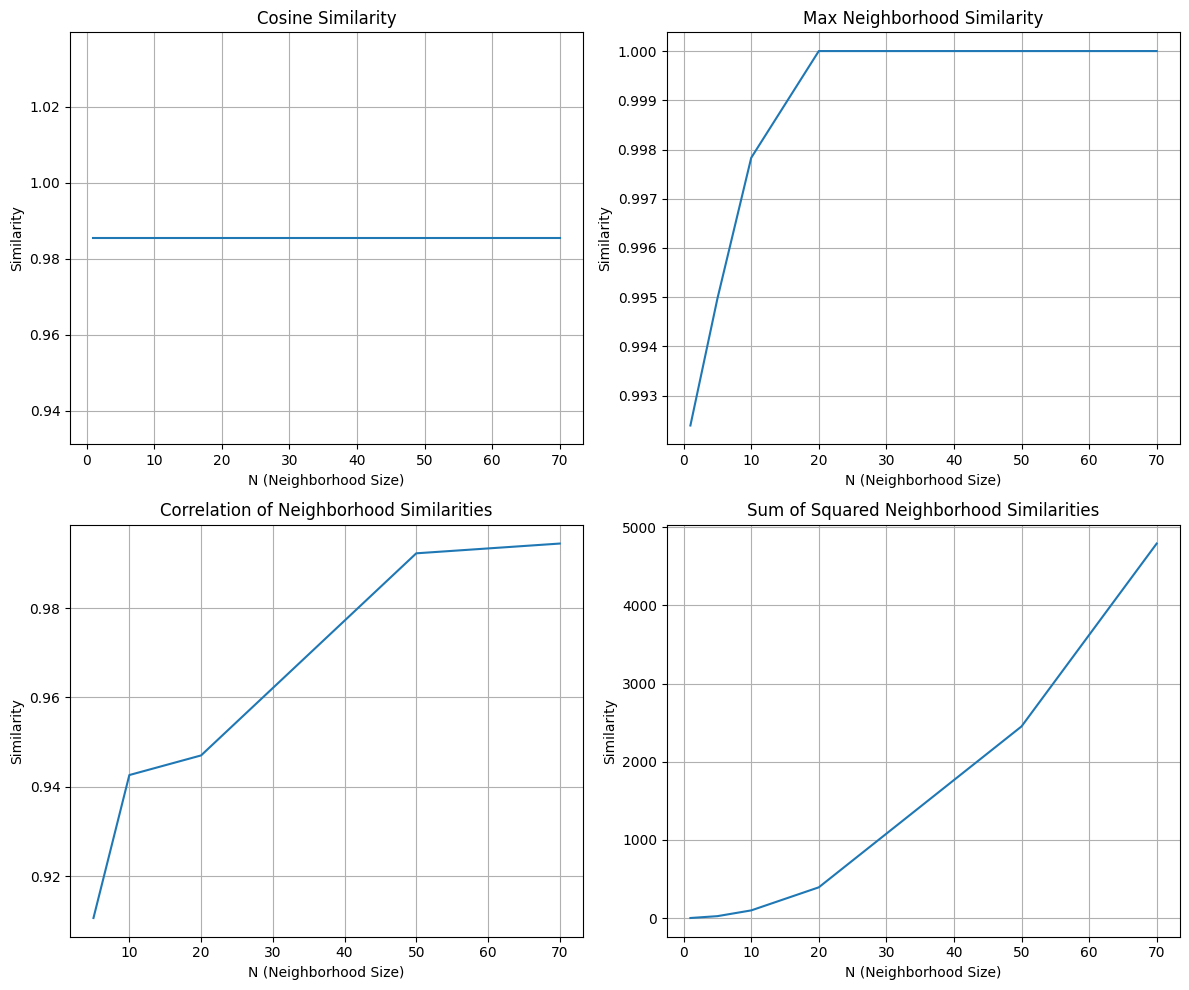

In [14]:
N_values = [1, 5, 10, 20, 50,70]
cosine_similarity_values = []
max_similarity_values = []
correlation_values = []
sum_squared_values = []

word1 = 'apartment'
word2 = 'place'

for N in N_values:
    cosine_similarity_values.append(calculate_similarity(word1, word2, word2vec_model))
    max_similarity_values.append(max_neighborhood_similarity(word1, word2, word2vec_model, N))
    correlation = correlation_of_neighborhood_similarities([word1, word2], word2vec_model, N)
    correlation_values.append(np.mean(correlation) if correlation is not None else None)
    sum_squared_values.append(sum_of_squared_neighborhood_similarities(word1, word2, word2vec_model, N))


plt.figure(figsize=(12, 10))

# Cosine Similarity
plt.subplot(2, 2, 1)
plt.plot(N_values, cosine_similarity_values)
plt.title('Cosine Similarity')
plt.xlabel('N (Neighborhood Size)')
plt.ylabel('Similarity')
plt.grid(True)

# Maximum Similarity of Neighborhoods
plt.subplot(2, 2, 2)
plt.plot(N_values, max_similarity_values)
plt.title('Max Neighborhood Similarity')
plt.xlabel('N (Neighborhood Size)')
plt.ylabel('Similarity')
plt.grid(True)

# Correlation of Neighborhood Similarities
plt.subplot(2, 2, 3)
plt.plot(N_values, correlation_values)
plt.title('Correlation of Neighborhood Similarities')
plt.xlabel('N (Neighborhood Size)')
plt.ylabel('Similarity')
plt.grid(True)

# Sum of Squared Neighborhood Similarities
plt.subplot(2, 2, 4)
plt.plot(N_values, sum_squared_values)
plt.title('Sum of Squared Neighborhood Similarities')
plt.xlabel('N (Neighborhood Size)')
plt.ylabel('Similarity')
plt.grid(True)

plt.tight_layout()
plt.show()



### **Observations**
---

Για το παραπάνω παράδειγμα παρατηρούμε τα εξής:


*   H Cosine Similarity παραμένει σταθερή μιας και είναι ανεξάρητητο από το n.
*   H  Maximum Similarity of Neighborhoods αυξάνεται καθώς αυξάνεται το n, ενώ φαίνεται να συγκλίνει σε μια σταθερή τιμή για μεγάλες τιμές του n.
*   Για μικρές τιμές του n, η Correlation of Neighborhood Similarities είναι υψηλή επειδή οι λέξεις έχουν λίγους γείτονες, οι οποίοι είναι πολύ κοντά στην έννοια τους. Καθώς το n αυξάνεται, η ποικιλία των λέξεων που θεωρούνται "γείτονες" αυξάνεται, μειώνοντας την ακρίβεια της συσχέτισης. Αυτό μπορεί να οδηγεί σε μια πτώση στη συσχέτιση των ομοιοτήτων των γειτονιών. Καθώς το n συνεχίζει να αυξάνεται, η ακρίβεια των γειτονιών μπορεί να αυξηθεί ξανά, καθιστώντας τη συσχέτιση των ομοιοτήτων των γειτονιών υψηλότερη.
*   Η αύξηση του "Sum of Squared Neighborhood Similarities" με την αύξηση του n, υποδεικνύει  ότι περιλαμβάνονται περισσότερες λέξεις στη γειτονιά της κάθε λέξης. Η αυξημένη ποικιλία των γειτονικών λέξεων μπορεί να οδηγήσει σε μεγαλύτερη πληροφορία σχετικά με τον χώρο των embeddings.



## **3.3 Present different word neighborhoods for N of your choice.**

In [15]:
word = 'house'
N = 5

neighbors = get_top_n_similar_words(word, word2vec_model, N)

print(f"Neighborhood words for '{word}' (N={N}):")
for neighbor in neighbors:
    print(neighbor)


Neighborhood words for 'house' (N=5):
space
flat
loved
better
big


In [16]:
word = 'house'
N = 10

neighbors = get_top_n_similar_words(word, word2vec_model, N)

print(f"Neighborhood words for '{word}' (N={N}):")
for neighbor in neighbors:
    print(neighbor)

Neighborhood words for 'house' (N=10):
space
flat
loved
better
big
felt
find
much
amenity
building


In [17]:
word = 'athens'
N = 5

neighbors = get_top_n_similar_words(word, word2vec_model, N)

print(f"Neighborhood words for '{word}' (N={N}):")
for neighbor in neighbors:
    print(neighbor)

Neighborhood words for 'athens' (N=5):
staying
anyone
enjoyed
visit
come


In [18]:
word = 'athens'
N = 10

neighbors = get_top_n_similar_words(word, word2vec_model, N)


print(f"Neighborhood words for '{word}' (N={N}):")
for neighbor in neighbors:
    print(neighbor)

Neighborhood words for 'athens' (N=10):
staying
anyone
enjoyed
visit
come
stay
place
home
wonderful
best


In [ ]:
from google.colab import runtime
runtime.unassign()